In [96]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as inte

# me gustan más estos colores para los plots
def colores_tableau():
    # Sources: http://www.randalolson.com/2014/06/28/how-to-make
    #            -beautiful-data-visualizations-in-python-with-matplotlib/
    # These are the "Tableau 20" colors as RGB.   
    tableau20=[(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),    
               (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),    
               (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),    
               (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
               (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib
    # accepts.    
    for i in range(len(tableau20)):    
        red, green, blue = tableau20[i]    
        tableau20[i] = (red / 255., green / 255., blue / 255.) 
    return tableau20

tableau20 = colores_tableau()

Ahora vamos a definir la red sobre la que realizaremos la simulación.

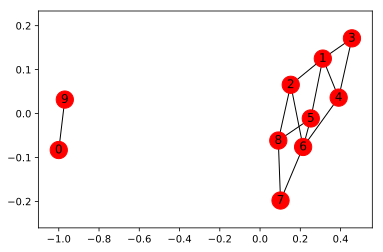

In [97]:
g=nx.Graph()

g.add_node(0)
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_node(4)
g.add_node(5)
g.add_node(6)
g.add_node(7)
g.add_node(8)
g.add_node(9)


g.add_edge(1,2)
g.add_edge(1,3)
g.add_edge(1,5)
g.add_edge(1,4)
g.add_edge(4,3)
g.add_edge(8,7)
g.add_edge(7,6)
g.add_edge(9,0)
g.add_edge(2,8)
g.add_edge(6,4)
g.add_edge(6,5)
g.add_edge(6,2)


g.add_edge(5,8)
#g.add_edge(7,9)


#g.number_of_nodes()
'''
def write_directed_vertex_list_to_file(g, filename):
    A=np.array(g.edges())
    A=np.append(A,A[:,[1,0]], axis=0)
    A=np.array(A[A[:,0].argsort()]).astype(int)
    np.savetxt(filename, A, fmt='%i')

write_directed_vertex_list_to_file(g,'net.net')
'''
NODE_NR = g.number_of_nodes()


#E=np.loadtxt('net.net')
A = nx.adjacency_matrix(g)
A = nx.to_numpy_matrix(g)

'''
C = np.zeros((int(NODE_NR),int(NODE_NR)))-1
for i in range(0,NODE_NR):
    k=0
    for j in range(0,NODE_NR): 
        if A[i,j]!=0:
            C[i][k]=j
            k = k + 1
            
gg=nx.read_adjlist("net.net")
'''
# Lo siguiente es para tener las componentes separadas.
connctd = sorted(nx.connected_components(g), key=len, reverse=True)
connctd = [np.array((list(i)),dtype=int) for i in connctd]
mat_C = []
for comp in connctd:
    mat_C.append(np.zeros(NODE_NR))
    for j in range(0,len(comp)):
        mat_C[-1][comp[j]] = 1
mat_C = np.array(mat_C)


#ones = np.matrix(np.ones(NODE_NR)).T
#theta_0 = -np.pi + 2*np.pi*np.random.rand(NODE_NR)
#theta_0 = (np.matrix(theta_0))

#s=np.sin(ones*(theta_0)-theta_0.T*(ones.T))
#A = np.matrix(A)
#s = np.matrix(s)
#print(A)
#print(s)
#np.matrix([(s[i]*A[i].T).item() for i in range(len(A))])

nx.draw_networkx(g)

Ahora vamos a integrar, de una forma algo ineficiente. Calculamos $\theta_j-\theta_i$ para todas las compinaciones y despues multiplicamos por la matriz de adyacencia, luego muchos de los $\theta_j-\theta_i$ realmente corresponden a un peso $0$. Tenía el miedo de que el uso de for's en Python puede ser más lento que hacer estas cuentas pero vectorizadas. El mismo dilema igual existe en matlab? Pero de todos modos, para N pequeño, da igual.

In [118]:
def velocity(t, y, arg1):
    c = arg1[0]
    w = arg1[1]
    A = arg1[2]
    y = np.matrix(y)
    ones = np.matrix(np.ones(NODE_NR)).T
    s=np.sin(ones*(y)-y.T*(ones.T))
    return w+np.asarray(c*np.matrix([(s[i]*A[i].T).item() for i in range(len(A))]))


def jacobian(t, y, arg2):
    c = arg2[0]
    A = arg2[1]
    y = np.matrix(y)
    ones = np.matrix(np.ones(NODE_NR)).T
    s=np.cos(ones*(y)-y.T*(ones.T))
    return 0

np.random.seed(777)
w=-0.5+np.random.rand(NODE_NR)
theta_0 = -np.pi + 2*np.pi*np.random.rand(NODE_NR)

COUPLING = 1.5
TIME_INITIAL = 0.0
TIME_FINAL = 1000.0
METHOD = 'LSODA'
#METHOD = 'RK45'
'''
ints = solve_ivp(lambda t,y: velocity(t,y,[COUPLING,w,A]),
                y0=theta_0,
                t_span=[TIME_INITIAL,TIME_FINAL],
                method=METHOD,
                dense_output=False)
'''
INTEGRATOR          = 'lsoda'
lambda t,y: jacobian(t,y,[COUPLING,w,A])
sol = inte.ode(lambda t,y: velocity(t,y,[COUPLING,w,A])).set_integrator(INTEGRATOR)

ode = sol.set_initial_value(theta_0, TIME_INITIAL)

DT = (TIME_FINAL-TIME_INITIAL)/100
DT = 1
t = []
y_t = ode.integrate(ode.t + DT)
t.append(ode.t)
y_t = [[y_t[i]] for i in range(0,NODE_NR)]
while ode.successful() and ode.t < TIME_FINAL:
    ode.integrate(ode.t + DT)
    t.append(ode.t)
    for i in range(0, NODE_NR):
        y_t[i].append(ode.y[i])
#print(y_t[0])
y_t = [np.array(y_t[i]) for i in range(0,len(y_t))]
y_t = np.array(y_t)

Ahora vamos a calcular la syncro total y de cada componente. También calculamos la fase.


In [124]:
def r_psi(theta):
    z = sum(np.exp(theta*1j))/len(theta)
    return np.array([np.absolute(z), np.angle(z)])

def r_psi_comp(theta, conn):
    z = (np.exp(theta*1j))
    # cada elto de out sera las r(t),psi(t) de una de las componentes disconexas
    out = []
    for comp in range(0,len(conn)):
        a = []
        for j in range(0,len(conn[comp])):
            # estamos metiendo todos los nodos j que pertenecem
            # a conn[i] en una lista para sumar despues
            a.append(np.exp(theta[j]*1j))  
        z = sum(a)/len(conn[comp])
        out.append(np.array([np.absolute(z), np.angle(z)]))
    return out


asd = ints.y
asd = y_t

out_comp = r_psi_comp(asd, connctd)
r, psi = r_psi(asd)

TRANSIENT = 20
# cuidado t_transiet en la f siguiente debe ser mayor que DT
def without_transient(vec, t_transient):
    return vec[int(t_transient*(TIME_FINAL-TIME_INITIAL)/len(vec)) : -1]

r_without_transient = without_transient(r, TRANSIENT)
r_mean = np.mean(r_without_transient)
r_var = np.sqrt(np.var(r_without_transient))

def mean_sig_components (out_comp, t_transient):
    r_mean_comp = []
    r_sig_comp  = []
    for i in range(0,len(out_comp)):
        aux_vec_no_transient = without_transient(out_comp[i][0], t_transient)
        r_mean_comp.append(np.mean(aux_vec_no_transient))
        r_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
    return r_mean_comp, r_sig_comp
      
r_mean_comp, r_sig_comp = mean_sig_components(out_comp, TRANSIENT)


print("r total = "+"{:.2f}".format(r_mean)+"+-"+"{:.2f}".format(r_var))
print("r com (de mayor componente a menor) :")
print(["{:.2f}".format((r_mean_comp[i]))+"+-"+"{:.2f}".format(np.sqrt(np.var(out_comp[i][0])))
                   for i in range(0,len(r_mean_comp))])

r total = 0.81+-0.14
r com (de mayor componente a menor) :
['0.88+-0.09', '0.64+-0.31']


Ahora tocan plots.

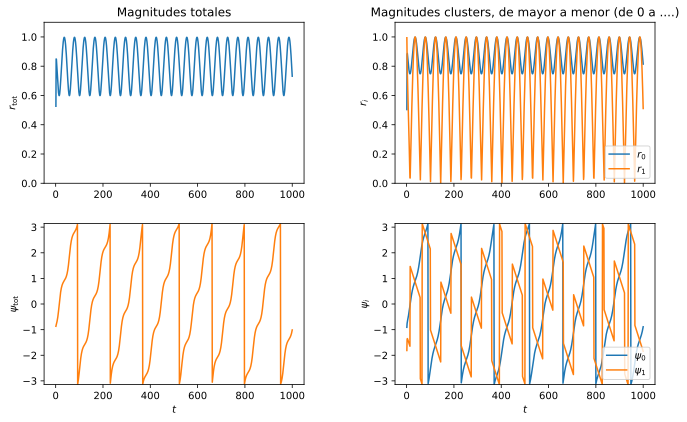

In [125]:
%config InlineBackend.figure_format = 'svg'

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.style.use('ggplot')
#plt.style.use('seaborn-talk')

plt.figure(figsize=(10,6))

time = t

plt.subplot(2, 2, 1)
plt.ylim([0,1.1])
plt.title("Magnitudes totales")
plt.plot(time,r,color=tableau20[0])#,label=r"$r$")
plt.ylabel('$r_{\mathrm{tot}}$')

plt.subplot(2, 2, 3)
plt.ylim([-np.pi,+np.pi])
plt.plot(time,psi,color=tableau20[2])#,label=r"$\psi$")
plt.ylabel('$\psi_{\mathrm{tot}}$')
plt.xlabel('$t$')

plt.subplot(2, 2, 2)
plt.title("Magnitudes clusters, de mayor a menor (de 0 a ....)")
plt.ylim([0,1.1])
for i in range(0,len(out_comp)):
    plt.plot(time,out_comp[i][0],label=r"$r_"+str(i)+"$",color=tableau20[2*i])
plt.ylabel(r'$r_{i}$')
plt.legend()

plt.subplot(2, 2, 4)
plt.ylim([-np.pi,+np.pi])
for i in range(0,len(out_comp)):
    plt.plot(time,out_comp[i][1],label=r"$\psi_"+str(i)+"$",color=tableau20[2*i])
plt.ylabel(r'$\psi_{i}$')
plt.xlabel(r'$t$')
plt.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


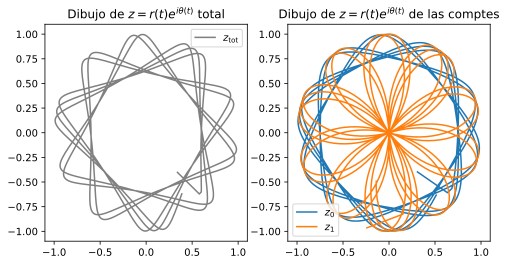

In [134]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ total")
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
aux_r = r
aux_psi = psi
aux_n = len(aux_r)
plt.plot(aux_r*np.cos(aux_psi),
         aux_r*np.sin(aux_psi),
         label=r"$z_{\mathrm{tot}}$",
         color = 'gray')
plt.legend()

plt.subplot(1,2,2)
plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ de las comptes")
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
for i in range(0,len(out_comp)):
    aux_r = out_comp[i][0]
    aux_psi = out_comp[i][1]
    aux_n = len(aux_r)
    plt.plot(aux_r*np.cos(aux_psi),
             aux_r*np.sin(aux_psi),
             label=r"$z_"+str(i)+"$")
plt.legend()
